## Khushbu Soni  

# 1 Model Complexity and Model Selection

## Q 1
### 1.1 Implement KNN Regressor




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.base import BaseEstimator
from scipy.spatial import KDTree
import numpy as np

class KnnRegressor(BaseEstimator):

    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors

    def fit(self, X_train, y_train):
        self.y_train_ = y_train
        self.X_train_kdtree_ = KDTree(X_train)
        return self

    def predict(self, X_test):
        _, neighbor_indices = self.X_train_kdtree_.query(X_test, k=self.n_neighbors)
        neighbor_indices = neighbor_indices.reshape(len(X_test), self.n_neighbors)
        predictions = np.mean(self.y_train_[neighbor_indices], axis=1)
        return predictions


### 1.2 Tesing the KNN class

In [ ]:
from sklearn.datasets import load_diabetes
import numpy as np

# Load the diabetes dataset
diabetes = load_diabetes()

# Custom train_test_split function
def train_test_split(X, y, train_size=0.7, random_state=None):
    RNG = np.random.default_rng(random_state)
    N = len(X)
    N_train = round(N * train_size)
    idx_train = RNG.choice(N, N_train, replace=False)
    idx_test = np.setdiff1d(np.arange(N), idx_train)
    RNG.shuffle(idx_test)
    return X[idx_train], X[idx_test], y[idx_train], y[idx_test]

# Split the diabetes dataset into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, train_size=0.7, random_state=0)

# Initialize the KNN Regressor with k=5
knn_regressor = KnnRegressor(n_neighbors=5)

# Fit the KNN Regressor to the training data
knn_regressor.fit(X_train, y_train)

# Predict on the test data
y_test_pred = knn_regressor.predict(X_test)

# Predict on the training data
y_train_pred = knn_regressor.predict(X_train)


In [ ]:
# Custom mean squared error function
def mean_squared_error(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean() / 2

# Calculate and print the training and test errors for the diabetes dataset
print("DIABETES DATASET")
print("Training Error (MSE):", mean_squared_error(y_train, y_train_pred))
print("Test Error (MSE):", mean_squared_error(y_test, y_test_pred))

DIABETES DATASET
Training Error (MSE): 1131.739935275081
Test Error (MSE): 2158.830676691729


## Q 2   L-Fold CrossValidation

### 2.1 Class L-Fold

In [ ]:
class LFold:

    def __init__(self, n_splits, shuffle=True, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, x=None, y=None, groups=None):
        return self.n_splits

    def split(self, x, y=None, groups=None):
        N = len(x)
        idx = np.arange(N)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(idx)
        split_size = round(N / self.n_splits)
        for i in range(self.n_splits):
            test_idx = idx[i * split_size:(i + 1) * split_size]
            train_idx = np.setdiff1d(idx, test_idx)
            yield train_idx, test_idx


In [ ]:
for idx_train, idx_test in LFold(5).split(list(range(20))):
 print(idx_train, idx_test)


[ 0  2  3  4  5  6  8  9 10 11 12 14 16 17 18 19] [ 7 15 13  1]
[ 0  1  3  4  7  9 10 11 12 13 14 15 16 17 18 19] [2 8 6 5]
[ 0  1  2  3  5  6  7  8  9 11 12 13 14 15 16 18] [10 17  4 19]
[ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 17 19] [16 12 18  0]
[ 0  1  2  4  5  6  7  8 10 12 13 15 16 17 18 19] [14 11  3  9]


### 2.2 Test the effect of the K

In [ ]:
def evaluation1(n_splits, dataset, k):
    """
    Perform L-Fold cross-validation for a specific KNN parameter 'k'.

    Parameters:
    n_splits (int): Number of splits/folds for cross-validation.
    dataset: Dataset with 'data' and 'target' attributes.
    k (int): Number of neighbors for KNN.

    Returns:
    tuple: Mean and standard deviation of the mean squared errors for training and test sets.
    """
    # Initialize results array
    results = np.zeros(shape=(n_splits, 2), dtype=object)
    lfold = LFold(n_splits=n_splits, shuffle=True, random_state=0)
    X = dataset.data
    y = dataset.target

    # Perform L-Fold cross-validation
    for fold_index, (train_indices, test_indices) in enumerate(lfold.split(X)):
        knn = KnnRegressor(k)
        knn.fit(X[train_indices], y[train_indices])
        y_train_pred = knn.predict(X[train_indices])
        y_test_pred = knn.predict(X[test_indices])
        results[fold_index, 0] = mean_squared_error(y[train_indices], y_train_pred)
        results[fold_index, 1] = mean_squared_error(y[test_indices], y_test_pred)

    # Calculate mean and standard deviation of errors
    mean_result = np.mean(results, axis=0, dtype=np.float64)
    std_result = np.std(results, axis=0, dtype=np.float64)
    return mean_result, std_result


def evaluation2(n_splits, dataset, max_k):
    """
    Evaluate KNN with L-Fold cross-validation for a range of K values.

    Parameters:
    n_splits (int): Number of splits/folds for cross-validation.
    dataset: Dataset with 'data' and 'target' attributes.
    max_k (int): Maximum value of 'k' to evaluate.

    Returns:
    tuple: Mean and standard deviation results for each 'k', and the best 'k'.
    """
    # Initialize arrays to store results
    mean_results = np.zeros(shape=(max_k, 2))
    std_results = np.zeros(shape=(max_k, 2))
    scores_per_k = []

    # Evaluate each K value
    for k in range(1, max_k + 1):
        mean_result, std_result = evaluation1(n_splits, dataset, k)
        mean_results[k - 1, :] = mean_result
        std_results[k - 1, :] = std_result
        scores_per_k.append(mean_result[1])  # Append test error mean

    # Determine the best 'k'
    best_k = np.argmin(scores_per_k) + 1

    return mean_results, std_results, best_k

mean_res, sted_res, best_k= evaluation2(15, diabetes, 50)

In [ ]:
# Display results
print(f"Mean Results:\n{mean_res}")
print(f"Standard Deviation Results:\n{sted_res}")
print(f"Best K: {best_k}")

Mean Results:
[[   0.         2935.65517241]
 [ 741.05702179 2226.25775862]
 [ 985.24786118 1968.10702427]
 [1140.16891646 1795.0487069 ]
 [1191.81544149 1803.05425287]
 [1276.62124249 1747.39505109]
 [1311.38522014 1697.90539526]
 [1335.23211133 1674.92081537]
 [1360.87596528 1659.73522066]
 [1378.01807506 1646.4418046 ]
 [1403.10979796 1648.34030588]
 [1417.82415534 1636.72183908]
 [1422.69732558 1642.09967354]
 [1431.48111915 1627.19177809]
 [1435.39663923 1620.89133078]
 [1444.02316479 1620.19915589]
 [1444.27442379 1610.11344708]
 [1446.43487679 1586.49544842]
 [1451.94793183 1598.2213965 ]
 [1464.97991848 1592.71779023]
 [1471.25435863 1601.55051998]
 [1480.85153766 1611.54026788]
 [1486.57300189 1614.38318884]
 [1492.85828639 1613.22603768]
 [1498.31866538 1611.38049103]
 [1506.99852763 1621.39758893]
 [1514.26474711 1620.76580893]
 [1519.72054827 1617.13031756]
 [1521.56760419 1630.53110145]
 [1526.94801166 1636.4612682 ]
 [1534.8570524  1637.68984535]
 [1543.53483727 1639.5834

### 2.3 plot the mean training and test errors against the choice of K


Evaluating for L = 5


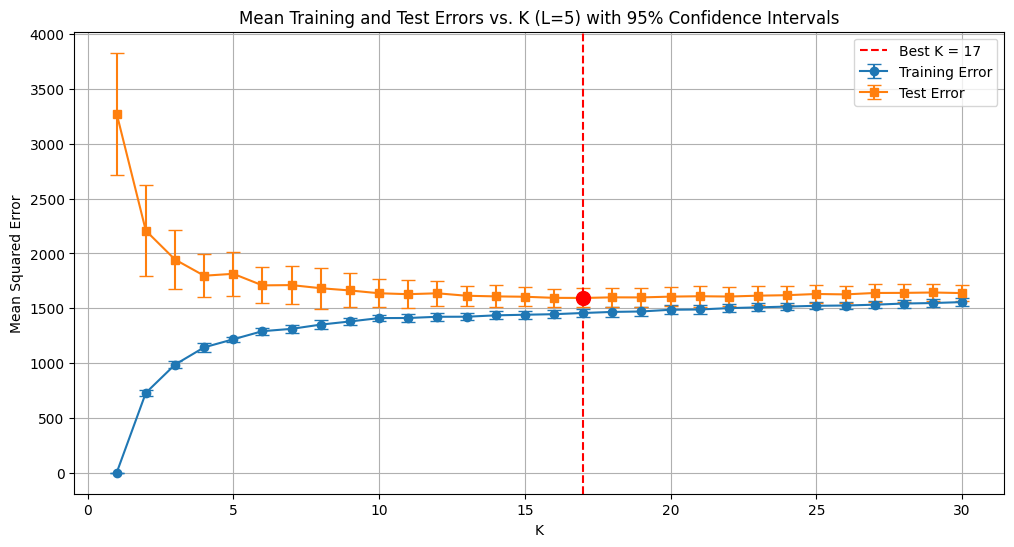

Evaluating for L = 10


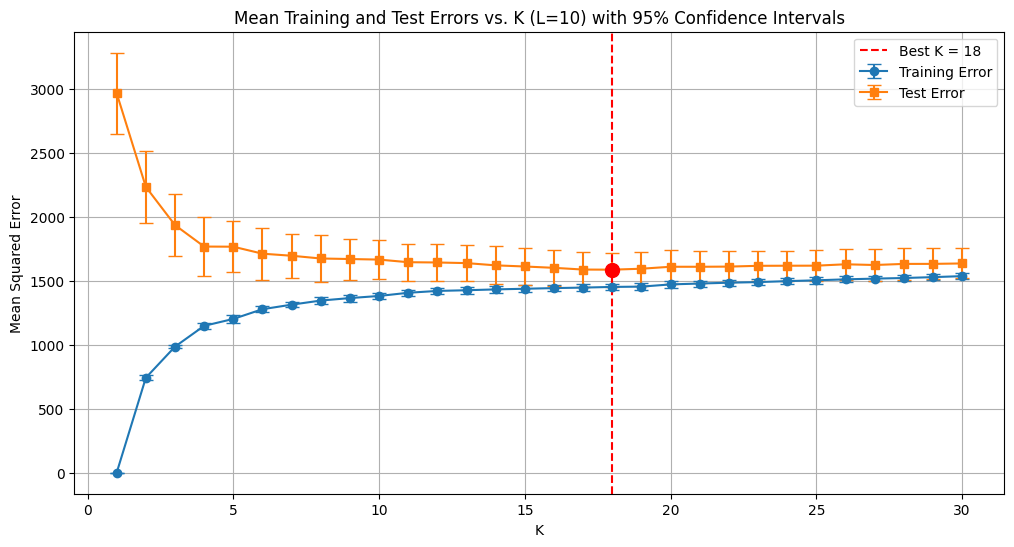

Evaluating for L = 15


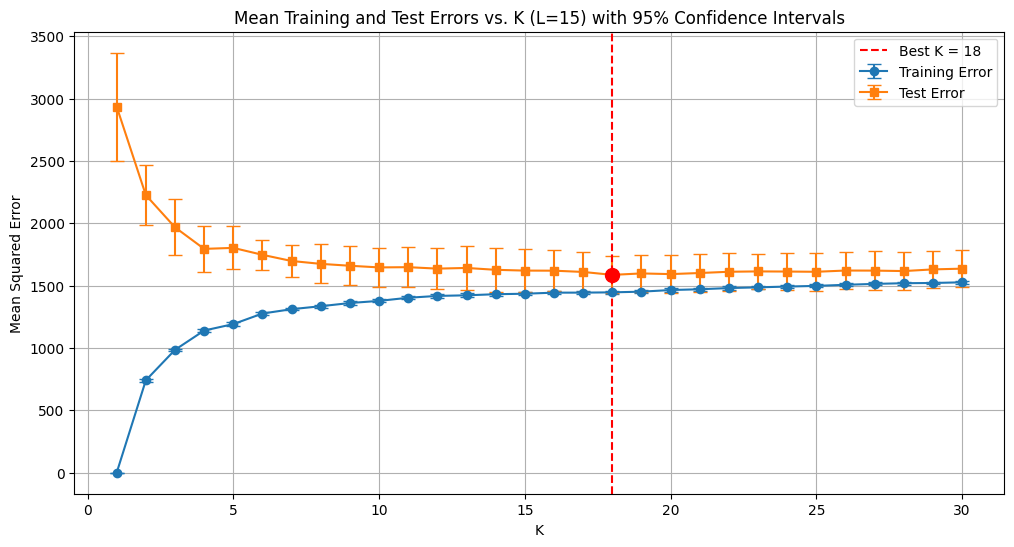

Evaluating for L = 20


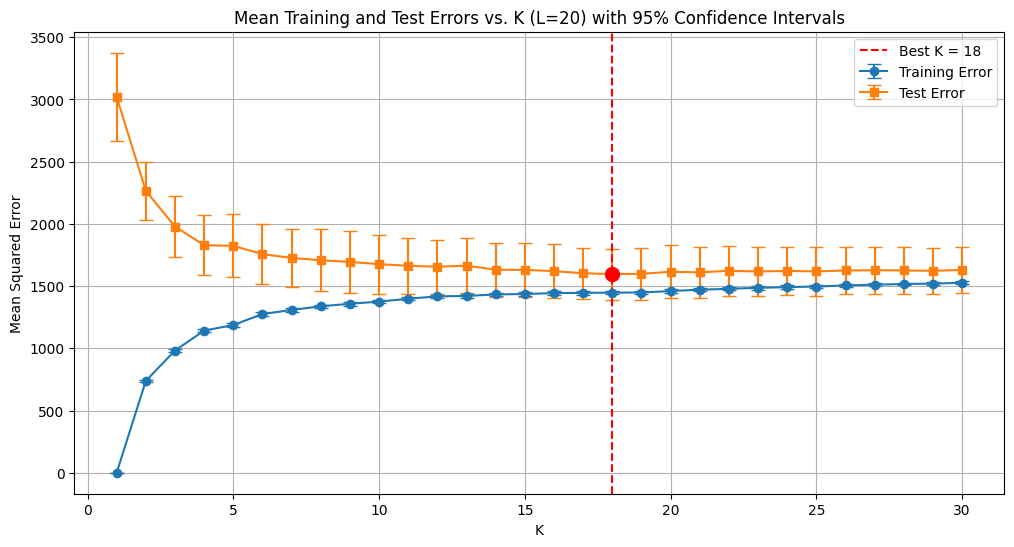

In [ ]:
import matplotlib.pyplot as plt

# Function to plot KNN performance for different L values
def plot_knn_performance(mean_results, std_results, L, max_k, best_k):
    k_values = np.arange(1, max_k + 1)
    confidence_interval_train = 1.96 * std_results[:, 0] / np.sqrt(L)
    confidence_interval_test = 1.96 * std_results[:, 1] / np.sqrt(L)

    plt.figure(figsize=(12, 6))
    plt.errorbar(k_values, mean_results[:, 0], yerr=confidence_interval_train, label='Training Error', fmt='-o', capsize=5)
    plt.errorbar(k_values, mean_results[:, 1], yerr=confidence_interval_test, label='Test Error', fmt='-s', capsize=5)

    # Highlight the best K
    plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best K = {best_k}')
    plt.scatter(best_k, mean_results[best_k - 1, 1], color='red', s=100, zorder=5)


    plt.title(f'Mean Training and Test Errors vs. K (L={L}) with 95% Confidence Intervals')
    plt.xlabel('K')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

# Different L values to test
L_values = [5, 10, 15, 20]
max_k = 30

# Iterate over different L values and plot
for L in L_values:
    print(f"Evaluating for L = {L}")
    mean_results, std_results, best_k = evaluation2(L, diabetes, max_k)
    plot_knn_performance(mean_results, std_results, L, max_k, best_k)

#### Effect of Parameter K:

Overfitting Region: For lower values of
K, the training error is low, and the test error is high. This indicates that the model is overfitting to the training data, capturing noise rather than generalizable patterns.

Underfitting Region: For higher values of K both training and test errors increase. The model becomes too simple, failing to capture the underlying data patterns, which leads to underfitting.

Optimal Region: The optimal
K values, around 17-18 in these plots, provide a balance between bias and variance, minimizing the test error and indicating good generalization to unseen data.

#### Effect of Parameter L:
With L=5: The confidence intervals are generally wider, indicating more variability in the model's performance across different folds. This suggests that fewer folds may lead to less stable estimates of model performance.

With L=10, 15, 20: The confidence intervals are narrower, indicating more consistent performance across folds. This is because increasing the number of folds generally provides a more robust estimate of the model's performance, reducing the variance in the error estimates.

Choosing K: The model's flexibility decreases as K increases. Small values of K lead to overfitting, while too large values lead to underfitting. An intermediate K provides a good balance.

Choosing L: Increasing L (number of folds) reduces the variance in performance estimates, providing more reliable assessments of model generalization but also increases computation time.



## Q 3 Automatic Model Selection
### 3.1 KNN Regressor CV

In [ ]:
# Implementation of KnnRegressorCV with internal cross-validation
class KnnRegressorCV(BaseEstimator):
    def __init__(self, ks=list(range(1, 21)), cv=LFold(5)):

        self.ks = ks
        self.cv = cv

    def fit(self, X, y):
        """
        Fit the KNN regressor using cross-validation to select the best K.

        Parameters:
        X (array-like): Training data features.
        y (array-like): Training data targets.

        Returns:
        self: Fitted estimator.
        """
        self.y_train_ = y
        self.X_train_kdtree_ = KDTree(X)
        scores_per_k = np.zeros((len(self.ks), self.cv.get_n_splits(X)))

        for k_idx, k in enumerate(self.ks):
            fold_idx = 0
            for train_indices, test_indices in self.cv.split(X):
                knn = KnnRegressor(n_neighbors=k)
                knn.fit(X[train_indices], y[train_indices])
                y_pred = knn.predict(X[test_indices])
                scores_per_k[k_idx, fold_idx] = mean_squared_error(y[test_indices], y_pred)
                fold_idx += 1

        self.best_k_ = self.ks[np.argmin(np.mean(scores_per_k, axis=1))]
        return self

    def predict(self, X):
        """
        Predict using the KNN regressor with the best K selected at fitting time.

        Parameters:
        X (array-like): Test data features.

        Returns:
        array-like: Predicted values.
        """
        _, neighbor_indices = self.X_train_kdtree_.query(X, k=self.best_k_)
        neighbor_indices = neighbor_indices.reshape(len(X), self.best_k_)
        predictions = np.mean(self.y_train_[neighbor_indices], axis=1)
        return predictions




### 3.2 Nested cross validation

In [ ]:
def nested_cv(dataset, k_options, num_outer_folds=5, num_inner_folds=5):
    """
    Perform nested cross-validation to evaluate the performance of KNN regressor
    with internal cross-validation for automatic K selection.

    Parameters:
    dataset (object): Dataset containing 'data' and 'target' attributes.
    k_options (list): List of K values to consider for the KNN regressor.
    num_outer_folds (int): Number of folds for the outer cross-validation.
    num_inner_folds (int): Number of folds for the inner cross-validation.

    Returns:
    float: Mean of chosen K values from the inner cross-validation across all outer folds.
    """
    X, y = dataset.data, dataset.target  # Extract features and target from the dataset
    outer_cv = LFold(n_splits=num_outer_folds, shuffle=True, random_state=0)  # Initialize outer CV using LFold

    # Arrays to store chosen K values and test scores for each outer fold
    chosen_ks = np.zeros(num_outer_folds, dtype=int)
    test_errors = np.zeros(num_outer_folds)

    # Perform outer cross-validation
    for fold_index, (train_indices, test_indices) in enumerate(outer_cv.split(X)):
        # Split the data into training and test sets for the current outer fold
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Initialize KNN regressor with cross-validation to select the best K
        knn_cv = KnnRegressorCV(ks=k_options, cv=LFold(n_splits=num_inner_folds, shuffle=True, random_state=0))
        knn_cv.fit(X_train, y_train)  # Fit the model with internal CV on the training data

        # Store the chosen K from internal CV for the current outer fold
        chosen_ks[fold_index] = knn_cv.best_k_

        # Predict on the outer test set and compute the test error
        test_error = mean_squared_error(y_test, knn_cv.predict(X_test))
        test_errors[fold_index] = test_error

    # Output the chosen K values for each outer fold
    print("Chosen K values from inner CV for each outer fold:", chosen_ks)

    # Calculate the mean chosen K and mean test error across all outer folds
    mean_chosen_k = np.mean(chosen_ks)
    mean_test_error = np.mean(test_errors)

    # Output the results
    print(f"Mean chosen K from internal cross-validation: {mean_chosen_k}")
    print(f"Mean test error from outer cross-validation: {mean_test_error}")

    return mean_chosen_k

# Perform nested cross-validation for the diabetes dataset
ks_range = list(range(1, 21))
mean_k_diabetes = nested_cv(diabetes, ks_range)
print(f"Mean chosen K for the diabetes dataset: {mean_k_diabetes}")


Chosen K values from inner CV for each outer fold: [14 15 11 20 19]
Mean chosen K from internal cross-validation: 15.8
Mean test error from outer cross-validation: 1626.7247892420914
Mean chosen K for the diabetes dataset: 15.8


Correspondence of Internal CV to Outer Test Sets:

Internal vs. Outer Cross-Validation:
The output indicates that the mean chosen K from internal cross-validation is 15.8. However, it does not directly compare this to a single "best" K from the outer test sets but provides insight into how consistent and reliable the internal cross-validation is in selecting K values that perform well on unseen data.

Generalization and Model Selection: The relatively stable test error (1626.72 MSE) across outer folds, combined with the mean chosen K, suggests that the internal cross-validation is reasonably successful in identifying K values that generalize well.

The output indicates that the internal cross-validation procedure was fairly effective in selecting K values that generalized well to the outer test sets for the diabetes dataset. The mean chosen K of 15.8 suggests an optimal balance between overfitting and underfitting for this specific dataset. However, the variation in chosen K values across folds highlights the importance of considering multiple folds and understanding the potential variability due to different data splits.